In [ ]:
!pip install nb-black

In [2]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
import sys

sys.path.insert(0, "../")

## Dataset

In [4]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [5]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [6]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    in_mem=True,
)

In [7]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

tensor(-22.1658, dtype=torch.float64) tensor(18.0601, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [8]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [9]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Model

In [10]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

In [11]:
import torch.optim as optim

In [12]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [19]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        conv2d_batch_out_channels_1 = 40

        self.conv2d_1 = nn.Conv2d(
            in_channels=1,
            out_channels=conv2d_batch_out_channels_1,
            kernel_size=(1, 1),
            padding="same",
            stride=1,
        )

        self.batch_norm_1 = nn.BatchNorm2d(num_features=conv2d_batch_out_channels_1)

        self.activation = nn.ReLU()

        conv2d_batch_out_channels_2 = 40

        self.conv2d_2 = nn.Conv2d(
            in_channels=1,
            out_channels=conv2d_batch_out_channels_2,
            kernel_size=(1, 1),
            padding="same",
            stride=1,
        )

        self.batch_norm_2 = nn.BatchNorm2d(num_features=conv2d_batch_out_channels_2)

        self.flatten = nn.Flatten()

        drop_out_1 = 0.3
        self.drop_out_1 = nn.Dropout(p=drop_out_1)

        self.fc1 = nn.Linear(3520, 40)

        drop_out_2 = 0.2
        self.drop_out_2 = nn.Dropout(p=drop_out_2)

        self.fc2 = nn.Linear(40, 10)

        self.fc = nn.Linear(10, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        features = features.unsqueeze_(1)
        features = features.unsqueeze_(-1)

        x = self.conv2d_1(features)
        x = self.batch_norm_1(x)
        x = self.activation(x)

        x = self.conv2d_2(features)
        x = self.batch_norm_2(x)
        x = self.activation(x)

        x = self.flatten(x)

        # print(f"{x.size() = }")

        x = self.drop_out_1(x)
        x = self.fc1(x)
        x = self.activation(x)

        x = self.drop_out_2(x)
        x = self.fc2(x)
        x = self.activation(x)

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22,
    num_features=22,
    num_bands=1,
    num_windows=1,
    num_labels=4,
    mode="csp",
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
net = net.to("cuda")
optimizer = optim.SGD(
    net.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=0
)

# optimizer = optim.SGD(
#     [
#         {"params": net.conv1.parameters()},
#         {"params": net.fc1.parameters(), "weight_decay": 5e-3},
#         {"params": net.fc.parameters()},
#     ],
#     lr=0.001,
#     momentum=0.9,
#     nesterov=True,
#     weight_decay=0,
# )

# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [20]:
signals = torch.empty((10, 22, 1, 16, 769), dtype=torch.float32).random_(1, 50)
signals = signals.to("cuda")
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 4, 22]))

## Train Loop

In [21]:
net = net.cuda()
net = net.to("cuda")
net

CSPNNCls(
  (conv1): CSPNN(
    (cspw): ModuleDict(
      (label-1_band-0_window-0): CSP()
      (label-2_band-0_window-0): CSP()
      (label-3_band-0_window-0): CSP()
      (label-4_band-0_window-0): CSP()
    )
  )
  (conv2d_1): Conv2d(1, 40, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (batch_norm_1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (conv2d_2): Conv2d(1, 40, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (batch_norm_2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (drop_out_1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3520, out_features=40, bias=True)
  (drop_out_2): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=40, out_features=10, bias=True)
  (fc): Linear(in_features=10, out_features=4, bias=True)
)

In [23]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [23]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [ ]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "train_kappa": [],
    "test_kappa": [],
    "train_fmeasure": [],
    "test_fmeasure": [],
    "lr": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    # params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    params = ["acc", "kappa", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])
    history["train_fmeasure"].append(tr[2])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])
    history["test_fmeasure"].append(ev[2])


Epoch  0


81it [00:04, 18.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3869811134573855


Train -  [0.3013117283950617, 0.06841563786008231, 0.3013117283950617, tensor(1.3866)]
Validation -  [0.30362654320987653, 0.07150205761316875, 0.30362654320987653, tensor(1.3865)]

Epoch  1


81it [00:04, 18.92it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3864086321842524


Train -  [0.31905864197530864, 0.09207818930041156, 0.31905864197530864, tensor(1.3859)]
Validation -  [0.3167438271604938, 0.08899176954732513, 0.3167438271604938, tensor(1.3859)]

Epoch  2


81it [00:04, 17.89it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3864572180642023


Train -  [0.26350308641975306, 0.01800411522633749, 0.26350308641975306, tensor(1.3852)]
Validation -  [0.2650462962962963, 0.020061728395061706, 0.2650462962962963, tensor(1.3851)]

Epoch  3


81it [00:04, 18.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3860147897108102


Train -  [0.2623456790123457, 0.016460905349794275, 0.2623456790123457, tensor(1.3847)]
Validation -  [0.25925925925925924, 0.012345679012345734, 0.25925925925925924, tensor(1.3845)]

Epoch  4


81it [00:04, 18.27it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3847767806347506


Train -  [0.2839506172839506, 0.04526748971193417, 0.2839506172839506, tensor(1.3839)]
Validation -  [0.2827932098765432, 0.043724279835390956, 0.2827932098765432, tensor(1.3839)]

Epoch  5


81it [00:04, 18.71it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.384239051077101


Train -  [0.2762345679012346, 0.034979423868312765, 0.2762345679012346, tensor(1.3832)]
Validation -  [0.2797067901234568, 0.039609053497942415, 0.2797067901234568, tensor(1.3831)]

Epoch  6


81it [00:04, 18.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3839673245394672


Train -  [0.3055555555555556, 0.07407407407407407, 0.3055555555555556, tensor(1.3827)]
Validation -  [0.3013117283950617, 0.06841563786008231, 0.3013117283950617, tensor(1.3825)]

Epoch  7


81it [00:04, 17.72it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3835500434592918


Train -  [0.27739197530864196, 0.03652263374485598, 0.27739197530864196, tensor(1.3818)]
Validation -  [0.2797067901234568, 0.039609053497942415, 0.2797067901234568, tensor(1.3817)]

Epoch  8


81it [00:04, 18.29it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3821690450479955


Train -  [0.27662037037037035, 0.035493827160493874, 0.27662037037037035, tensor(1.3809)]
Validation -  [0.2785493827160494, 0.0380658436213992, 0.2785493827160494, tensor(1.3808)]

Epoch  9


81it [00:04, 17.95it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3819684952865412


Train -  [0.3125, 0.08333333333333337, 0.3125, tensor(1.3801)]
Validation -  [0.3090277777777778, 0.07870370370370372, 0.3090277777777778, tensor(1.3801)]

Epoch  10


81it [00:04, 18.81it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3805829566202046


Train -  [0.2708333333333333, 0.02777777777777779, 0.2708333333333333, tensor(1.3793)]
Validation -  [0.26697530864197533, 0.02263374485596703, 0.26697530864197533, tensor(1.3792)]

Epoch  11


81it [00:04, 18.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3799282488999542


Train -  [0.30864197530864196, 0.07818930041152261, 0.30864197530864196, tensor(1.3781)]
Validation -  [0.30478395061728397, 0.07304526748971196, 0.30478395061728397, tensor(1.3783)]

Epoch  12


81it [00:04, 18.08it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3793398377336101


Train -  [0.32947530864197533, 0.1059670781893004, 0.32947530864197533, tensor(1.3773)]
Validation -  [0.33487654320987653, 0.11316872427983538, 0.33487654320987653, tensor(1.3776)]

Epoch  13


81it [00:04, 18.90it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.377907727971489


Train -  [0.2924382716049383, 0.05658436213991769, 0.2924382716049383, tensor(1.3759)]
Validation -  [0.28896604938271603, 0.05195473251028804, 0.28896604938271603, tensor(1.3760)]

Epoch  14


81it [00:04, 18.79it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3760327144905373


Train -  [0.3082561728395062, 0.07767489711934161, 0.3082561728395062, tensor(1.3746)]
Validation -  [0.30401234567901236, 0.07201646090534974, 0.30401234567901236, tensor(1.3748)]

Epoch  15


81it [00:04, 18.22it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3755302120138098


Train -  [0.2951388888888889, 0.06018518518518523, 0.2951388888888889, tensor(1.3734)]
Validation -  [0.2943672839506173, 0.05915637860082301, 0.2943672839506173, tensor(1.3737)]

Epoch  16


81it [00:04, 19.03it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3736906242959293


Train -  [0.3387345679012346, 0.11831275720164613, 0.3387345679012346, tensor(1.3712)]
Validation -  [0.33796296296296297, 0.11728395061728392, 0.33796296296296297, tensor(1.3716)]

Epoch  17


81it [00:04, 18.92it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3718448244495156


Train -  [0.35262345679012347, 0.13683127572016462, 0.35262345679012347, tensor(1.3696)]
Validation -  [0.3595679012345679, 0.14609053497942381, 0.3595679012345679, tensor(1.3701)]

Epoch  18


81it [00:04, 18.41it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.369760027638188


Train -  [0.3433641975308642, 0.12448559670781889, 0.3433641975308642, tensor(1.3674)]
Validation -  [0.34375, 0.125, 0.34375, tensor(1.3683)]

Epoch  19


81it [00:04, 17.67it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3700324591295219


Train -  [0.36072530864197533, 0.14763374485596703, 0.3607253086419753, tensor(1.3654)]
Validation -  [0.36496913580246915, 0.1532921810699589, 0.36496913580246915, tensor(1.3663)]

Epoch  20


81it [00:04, 18.77it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3681716168368305


Train -  [0.3159722222222222, 0.08796296296296291, 0.3159722222222222, tensor(1.3641)]
Validation -  [0.3128858024691358, 0.08384773662551437, 0.3128858024691358, tensor(1.3649)]

Epoch  21


81it [00:04, 18.41it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.36273134637762


Train -  [0.3506944444444444, 0.1342592592592593, 0.3506944444444444, tensor(1.3602)]
Validation -  [0.3568672839506173, 0.14248971193415638, 0.3568672839506173, tensor(1.3613)]

Epoch  22


81it [00:04, 18.47it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3633115806697327


Train -  [0.3707561728395062, 0.16100823045267487, 0.3707561728395062, tensor(1.3568)]
Validation -  [0.3773148148148148, 0.16975308641975306, 0.3773148148148149, tensor(1.3586)]

Epoch  23


81it [00:04, 18.50it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3616984552807279


Train -  [0.34760802469135804, 0.13014403292181065, 0.34760802469135804, tensor(1.3546)]
Validation -  [0.3541666666666667, 0.13888888888888884, 0.3541666666666667, tensor(1.3564)]

Epoch  24


81it [00:04, 18.00it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3577680455313788


Train -  [0.39467592592592593, 0.1929012345679012, 0.3946759259259259, tensor(1.3509)]
Validation -  [0.38657407407407407, 0.1820987654320988, 0.38657407407407407, tensor(1.3532)]

Epoch  25


81it [00:04, 18.93it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3553608140827698


Train -  [0.3549382716049383, 0.13991769547325106, 0.3549382716049383, tensor(1.3477)]
Validation -  [0.36072530864197533, 0.14763374485596703, 0.3607253086419753, tensor(1.3498)]

Epoch  26


81it [00:04, 18.81it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3511999874939153


Train -  [0.38233024691358025, 0.17644032921810704, 0.3823302469135802, tensor(1.3437)]
Validation -  [0.3784722222222222, 0.17129629629629628, 0.3784722222222222, tensor(1.3462)]

Epoch  27


81it [00:04, 18.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3490996463799183


Train -  [0.40239197530864196, 0.2031893004115226, 0.40239197530864196, tensor(1.3414)]
Validation -  [0.3869598765432099, 0.1826131687242798, 0.3869598765432099, tensor(1.3448)]

Epoch  28


81it [00:04, 18.02it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3464159200220933


Train -  [0.39699074074074076, 0.19598765432098764, 0.39699074074074076, tensor(1.3360)]
Validation -  [0.39814814814814814, 0.19753086419753085, 0.39814814814814814, tensor(1.3400)]

Epoch  29


81it [00:04, 19.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3407214070543831


Train -  [0.4012345679012346, 0.2016460905349794, 0.4012345679012346, tensor(1.3329)]
Validation -  [0.3873456790123457, 0.1831275720164609, 0.3873456790123457, tensor(1.3357)]

Epoch  30


81it [00:04, 16.46it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3406881079261685


Train -  [0.4050925925925926, 0.20679012345679015, 0.4050925925925926, tensor(1.3281)]
Validation -  [0.39891975308641975, 0.19855967078189296, 0.3989197530864198, tensor(1.3331)]

Epoch  31


81it [00:04, 17.95it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3336087774347376


Train -  [0.40007716049382713, 0.20010288065843618, 0.40007716049382713, tensor(1.3228)]
Validation -  [0.39699074074074076, 0.19598765432098764, 0.39699074074074076, tensor(1.3274)]

Epoch  32


81it [00:04, 17.28it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3308177995093076


Train -  [0.4185956790123457, 0.22479423868312753, 0.4185956790123457, tensor(1.3190)]
Validation -  [0.39776234567901236, 0.19701646090534974, 0.39776234567901236, tensor(1.3229)]

Epoch  33


81it [00:04, 17.79it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3303047315573986


Train -  [0.41898148148148145, 0.22530864197530864, 0.41898148148148145, tensor(1.3146)]
Validation -  [0.41087962962962965, 0.21450617283950613, 0.41087962962962965, tensor(1.3204)]

Epoch  34


81it [00:04, 18.96it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3254907293084226


Train -  [0.41010802469135804, 0.21347736625514402, 0.41010802469135804, tensor(1.3119)]
Validation -  [0.404320987654321, 0.20576131687242794, 0.40432098765432095, tensor(1.3171)]

Epoch  35


81it [00:04, 17.55it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3239332305060492


Train -  [0.4224537037037037, 0.2299382716049383, 0.4224537037037037, tensor(1.3076)]
Validation -  [0.41473765432098764, 0.21965020576131689, 0.41473765432098764, tensor(1.3136)]

Epoch  36


81it [00:04, 16.80it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.316904694945724


Train -  [0.4263117283950617, 0.23508230452674894, 0.4263117283950617, tensor(1.3042)]
Validation -  [0.41280864197530864, 0.21707818930041156, 0.41280864197530864, tensor(1.3112)]

Epoch  37


81it [00:04, 18.03it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3159223956826291


Train -  [0.4263117283950617, 0.23508230452674894, 0.4263117283950617, tensor(1.3062)]
Validation -  [0.4066358024691358, 0.20884773662551437, 0.40663580246913583, tensor(1.3111)]

Epoch  38


81it [00:04, 18.69it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3164887604890045


Train -  [0.4228395061728395, 0.2304526748971193, 0.4228395061728395, tensor(1.3022)]
Validation -  [0.4131944444444444, 0.21759259259259256, 0.4131944444444444, tensor(1.3057)]

Epoch  39


81it [00:04, 18.22it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3102390059718378


Train -  [0.4359567901234568, 0.24794238683127567, 0.4359567901234568, tensor(1.2946)]
Validation -  [0.4212962962962963, 0.22839506172839508, 0.4212962962962963, tensor(1.3017)]

Epoch  40


81it [00:04, 18.28it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3103664657216014


Train -  [0.41782407407407407, 0.22376543209876543, 0.41782407407407407, tensor(1.2981)]
Validation -  [0.41358024691358025, 0.21810699588477367, 0.41358024691358025, tensor(1.3017)]

Epoch  41


81it [00:04, 18.12it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.306309942845945


Train -  [0.4382716049382716, 0.2510288065843621, 0.4382716049382716, tensor(1.2902)]
Validation -  [0.4216820987654321, 0.22890946502057619, 0.4216820987654321, tensor(1.2992)]

Epoch  42


81it [00:04, 18.88it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.305639968978034


Train -  [0.4236111111111111, 0.2314814814814815, 0.4236111111111111, tensor(1.2938)]
Validation -  [0.40933641975308643, 0.2124485596707819, 0.40933641975308643, tensor(1.3033)]

Epoch  43


81it [00:04, 17.53it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3086721735236087


Train -  [0.44405864197530864, 0.2587448559670782, 0.44405864197530864, tensor(1.2859)]
Validation -  [0.4216820987654321, 0.22890946502057619, 0.4216820987654321, tensor(1.2964)]

Epoch  44


81it [00:04, 17.98it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3011585841944189


Train -  [0.4332561728395062, 0.24434156378600824, 0.4332561728395062, tensor(1.2869)]
Validation -  [0.4212962962962963, 0.22839506172839508, 0.4212962962962963, tensor(1.2934)]

Epoch  45


81it [00:04, 19.42it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3044321404563055


Train -  [0.4382716049382716, 0.2510288065843621, 0.4382716049382716, tensor(1.2808)]
Validation -  [0.43171296296296297, 0.24228395061728392, 0.43171296296296297, tensor(1.2865)]

Epoch  46


81it [00:04, 17.97it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.294657696912318


Train -  [0.44598765432098764, 0.2613168724279835, 0.44598765432098764, tensor(1.2806)]
Validation -  [0.43094135802469136, 0.2412551440329218, 0.43094135802469136, tensor(1.2890)]

Epoch  47


81it [00:04, 18.91it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2940214857643033


Train -  [0.4471450617283951, 0.26286008230452673, 0.4471450617283951, tensor(1.2768)]
Validation -  [0.43209876543209874, 0.24279835390946503, 0.43209876543209874, tensor(1.2854)]

Epoch  48


81it [00:04, 18.89it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2963661279207395


Train -  [0.44367283950617287, 0.2582304526748971, 0.44367283950617287, tensor(1.2756)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.4340277777777778, tensor(1.2828)]

Epoch  49


81it [00:04, 18.54it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2892964401362854


Train -  [0.44367283950617287, 0.2582304526748971, 0.44367283950617287, tensor(1.2773)]
Validation -  [0.4236111111111111, 0.2314814814814815, 0.4236111111111111, tensor(1.2872)]

Epoch  50


81it [00:04, 17.44it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2886778513590496


Train -  [0.435570987654321, 0.24742798353909468, 0.435570987654321, tensor(1.2820)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.4201388888888889, tensor(1.2961)]

Epoch  51


81it [00:04, 18.18it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2842752859916216


Train -  [0.44483024691358025, 0.2597736625514403, 0.44483024691358025, tensor(1.2706)]
Validation -  [0.44405864197530864, 0.2587448559670782, 0.44405864197530864, tensor(1.2773)]

Epoch  52


81it [00:04, 18.51it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.287053202405388


Train -  [0.4506172839506173, 0.2674897119341564, 0.4506172839506173, tensor(1.2661)]
Validation -  [0.4417438271604938, 0.25565843621399176, 0.4417438271604938, tensor(1.2755)]

Epoch  53


81it [00:04, 18.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2835799117147186


Train -  [0.45717592592592593, 0.2762345679012346, 0.45717592592592593, tensor(1.2665)]
Validation -  [0.43287037037037035, 0.24382716049382713, 0.43287037037037035, tensor(1.2826)]

Epoch  54


81it [00:04, 17.97it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2818807981632374


Train -  [0.4548611111111111, 0.27314814814814814, 0.4548611111111111, tensor(1.2691)]
Validation -  [0.4216820987654321, 0.22890946502057619, 0.4216820987654321, tensor(1.2855)]

Epoch  55


81it [00:04, 17.59it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2852168774899142


Train -  [0.45447530864197533, 0.27263374485596703, 0.45447530864197533, tensor(1.2618)]
Validation -  [0.44675925925925924, 0.26234567901234573, 0.44675925925925924, tensor(1.2717)]

Epoch  56


81it [00:04, 18.25it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2803714746310386


Train -  [0.46026234567901236, 0.2803497942386831, 0.46026234567901236, tensor(1.2601)]
Validation -  [0.44521604938271603, 0.2602880658436214, 0.44521604938271603, tensor(1.2727)]

Epoch  57


81it [00:04, 18.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.284817139307658


Train -  [0.45794753086419754, 0.2772633744855967, 0.45794753086419754, tensor(1.2638)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.4409722222222222, tensor(1.2768)]

Epoch  58


81it [00:04, 17.78it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2797716355618136


Train -  [0.4683641975308642, 0.29115226337448563, 0.4683641975308643, tensor(1.2586)]
Validation -  [0.44598765432098764, 0.2613168724279835, 0.44598765432098764, tensor(1.2696)]

Epoch  59


81it [00:04, 18.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.278991272420059


Train -  [0.46141975308641975, 0.28189300411522633, 0.46141975308641975, tensor(1.2626)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.4386574074074074, tensor(1.2791)]

Epoch  60


81it [00:04, 18.00it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.275217846587852


Train -  [0.45447530864197533, 0.27263374485596703, 0.45447530864197533, tensor(1.2589)]
Validation -  [0.4506172839506173, 0.2674897119341564, 0.4506172839506173, tensor(1.2675)]

Epoch  61


81it [00:04, 18.76it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.27889413745315


Train -  [0.4618055555555556, 0.28240740740740744, 0.4618055555555556, tensor(1.2593)]
Validation -  [0.45100308641975306, 0.2680041152263375, 0.45100308641975306, tensor(1.2714)]

Epoch  62


81it [00:04, 18.00it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2772044193597487


Train -  [0.45871913580246915, 0.2782921810699589, 0.45871913580246915, tensor(1.2589)]
Validation -  [0.4564043209876543, 0.27520576131687247, 0.4564043209876543, tensor(1.2677)]

Epoch  63


81it [00:04, 18.82it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.27559502772343


Train -  [0.4660493827160494, 0.2880658436213992, 0.4660493827160494, tensor(1.2544)]
Validation -  [0.4498456790123457, 0.2664609053497943, 0.4498456790123457, tensor(1.2713)]

Epoch  64


81it [00:04, 18.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.276343329453174


Train -  [0.46412037037037035, 0.2854938271604939, 0.46412037037037035, tensor(1.2551)]
Validation -  [0.4386574074074074, 0.2515432098765432, 0.4386574074074074, tensor(1.2748)]

Epoch  65


81it [00:04, 18.99it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.273880300698457


Train -  [0.4529320987654321, 0.2705761316872428, 0.4529320987654321, tensor(1.2580)]
Validation -  [0.4529320987654321, 0.2705761316872428, 0.4529320987654321, tensor(1.2685)]

Epoch  66


81it [00:04, 18.46it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2717340816686182


Train -  [0.45987654320987653, 0.279835390946502, 0.45987654320987653, tensor(1.2550)]
Validation -  [0.44290123456790126, 0.257201646090535, 0.44290123456790126, tensor(1.2694)]

Epoch  67


81it [00:04, 18.63it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2663112231242803


Train -  [0.470679012345679, 0.29423868312757206, 0.47067901234567894, tensor(1.2603)]
Validation -  [0.42322530864197533, 0.2309670781893004, 0.42322530864197533, tensor(1.2824)]

Epoch  68


81it [00:04, 18.36it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2696492613097767


Train -  [0.4672067901234568, 0.2896090534979424, 0.4672067901234568, tensor(1.2513)]
Validation -  [0.45447530864197533, 0.27263374485596703, 0.45447530864197533, tensor(1.2684)]

Epoch  69


81it [00:04, 18.92it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2735060512283702


Train -  [0.48032407407407407, 0.3070987654320988, 0.48032407407407407, tensor(1.2487)]
Validation -  [0.45177469135802467, 0.2690329218106996, 0.45177469135802467, tensor(1.2672)]

Epoch  70


81it [00:04, 18.29it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2715013395121069


Train -  [0.4664351851851852, 0.2885802469135802, 0.4664351851851852, tensor(1.2585)]
Validation -  [0.43209876543209874, 0.24279835390946503, 0.43209876543209874, tensor(1.2811)]

Epoch  71


81it [00:04, 18.29it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2697360751069622


Train -  [0.46489197530864196, 0.286522633744856, 0.46489197530864196, tensor(1.2488)]
Validation -  [0.45601851851851855, 0.27469135802469136, 0.45601851851851855, tensor(1.2640)]

Epoch  72


81it [00:04, 18.30it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2682205497482677


Train -  [0.47337962962962965, 0.2978395061728395, 0.47337962962962965, tensor(1.2515)]
Validation -  [0.4471450617283951, 0.26286008230452673, 0.4471450617283951, tensor(1.2725)]

Epoch  73


81it [00:04, 18.00it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2679562583381747


Train -  [0.4845679012345679, 0.31275720164609055, 0.48456790123456794, tensor(1.2496)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.435570987654321, tensor(1.2749)]

Epoch  74


81it [00:04, 19.53it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2648673587375217


Train -  [0.47530864197530864, 0.3004115226337448, 0.47530864197530864, tensor(1.2544)]
Validation -  [0.4193672839506173, 0.22582304526748975, 0.4193672839506173, tensor(1.2803)]

Epoch  75


81it [00:04, 18.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2680904394314614


Train -  [0.4660493827160494, 0.2880658436213992, 0.4660493827160494, tensor(1.2475)]
Validation -  [0.4525462962962963, 0.2700617283950617, 0.4525462962962963, tensor(1.2639)]

Epoch  76


81it [00:04, 18.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.264768859486521


Train -  [0.47685185185185186, 0.30246913580246915, 0.47685185185185186, tensor(1.2491)]
Validation -  [0.44830246913580246, 0.26440329218106995, 0.44830246913580246, tensor(1.2702)]

Epoch  77


81it [00:04, 18.33it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2663243508633273


Train -  [0.4664351851851852, 0.2885802469135802, 0.4664351851851852, tensor(1.2463)]
Validation -  [0.4529320987654321, 0.2705761316872428, 0.4529320987654321, tensor(1.2644)]

Epoch  78


81it [00:04, 18.59it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2634407944149442


Train -  [0.49228395061728397, 0.32304526748971196, 0.49228395061728397, tensor(1.2442)]
Validation -  [0.44637345679012347, 0.2618312757201646, 0.44637345679012347, tensor(1.2684)]

Epoch  79


81it [00:04, 18.33it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2671611647547028


Train -  [0.49112654320987653, 0.32150205761316875, 0.49112654320987653, tensor(1.2471)]
Validation -  [0.44830246913580246, 0.26440329218106995, 0.44830246913580246, tensor(1.2674)]

Epoch  80


81it [00:04, 19.06it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2603571562119473


Train -  [0.47492283950617287, 0.2998971193415638, 0.47492283950617287, tensor(1.2512)]
Validation -  [0.4471450617283951, 0.26286008230452673, 0.4471450617283951, tensor(1.2680)]

Epoch  81


81it [00:04, 17.90it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2592772745791776


Train -  [0.4861111111111111, 0.31481481481481477, 0.4861111111111111, tensor(1.2482)]
Validation -  [0.4533179012345679, 0.2710905349794238, 0.4533179012345679, tensor(1.2645)]

Epoch  82


81it [00:04, 18.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2631900413536732


Train -  [0.48572530864197533, 0.31430041152263377, 0.48572530864197533, tensor(1.2404)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.4513888888888889, tensor(1.2636)]

Epoch  83


81it [00:04, 18.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2664231194390192


Train -  [0.4679783950617284, 0.2906378600823045, 0.4679783950617284, tensor(1.2456)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.4618055555555556, tensor(1.2584)]

Epoch  84


81it [00:04, 17.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2625858651267157


Train -  [0.4783950617283951, 0.30452674897119336, 0.4783950617283951, tensor(1.2480)]
Validation -  [0.435570987654321, 0.24742798353909468, 0.435570987654321, tensor(1.2740)]

Epoch  85


81it [00:04, 18.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2637795651400532


Train -  [0.49074074074074076, 0.32098765432098764, 0.49074074074074076, tensor(1.2417)]
Validation -  [0.45100308641975306, 0.2680041152263375, 0.45100308641975306, tensor(1.2621)]

Epoch  86


81it [00:04, 18.63it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2672614536167663


Train -  [0.4675925925925926, 0.2901234567901234, 0.4675925925925926, tensor(1.2466)]
Validation -  [0.4564043209876543, 0.27520576131687247, 0.4564043209876543, tensor(1.2614)]

Epoch  87


81it [00:04, 18.29it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2651013812901062


Train -  [0.48842592592592593, 0.3179012345679012, 0.48842592592592593, tensor(1.2386)]
Validation -  [0.45717592592592593, 0.2762345679012346, 0.45717592592592593, tensor(1.2614)]

Epoch  88


81it [00:04, 18.14it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2552887863583035


Train -  [0.48842592592592593, 0.3179012345679012, 0.48842592592592593, tensor(1.2390)]
Validation -  [0.46141975308641975, 0.28189300411522633, 0.46141975308641975, tensor(1.2553)]

Epoch  89


81it [00:04, 19.08it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2569463459061987


Train -  [0.46219135802469136, 0.28292181069958844, 0.46219135802469136, tensor(1.2525)]
Validation -  [0.44830246913580246, 0.26440329218106995, 0.44830246913580246, tensor(1.2667)]

Epoch  90


81it [00:04, 18.21it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2544837248178176


Train -  [0.48842592592592593, 0.3179012345679012, 0.48842592592592593, tensor(1.2378)]
Validation -  [0.4660493827160494, 0.2880658436213992, 0.4660493827160494, tensor(1.2550)]

Epoch  91


81it [00:04, 19.01it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2582381389759205


Train -  [0.4702932098765432, 0.29372427983539096, 0.4702932098765432, tensor(1.2505)]
Validation -  [0.44598765432098764, 0.2613168724279835, 0.44598765432098764, tensor(1.2670)]

Epoch  92


81it [00:04, 18.06it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2568669142546478


Train -  [0.4903549382716049, 0.32047325102880664, 0.4903549382716049, tensor(1.2357)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.4618055555555556, tensor(1.2569)]

Epoch  93


81it [00:04, 18.44it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2589143514633179


Train -  [0.48726851851851855, 0.316358024691358, 0.48726851851851855, tensor(1.2391)]
Validation -  [0.45601851851851855, 0.27469135802469136, 0.45601851851851855, tensor(1.2584)]

Epoch  94


81it [00:04, 18.92it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.261546633861683


Train -  [0.47453703703703703, 0.2993827160493827, 0.47453703703703703, tensor(1.2433)]
Validation -  [0.4525462962962963, 0.2700617283950617, 0.4525462962962963, tensor(1.2671)]

Epoch  95


81it [00:04, 19.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2559710858780662


Train -  [0.48649691358024694, 0.3153292181069959, 0.48649691358024694, tensor(1.2330)]
Validation -  [0.4645061728395062, 0.28600823045267487, 0.4645061728395062, tensor(1.2533)]

Epoch  96


81it [00:04, 17.83it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2540653693823167


Train -  [0.48572530864197533, 0.31430041152263377, 0.48572530864197533, tensor(1.2396)]
Validation -  [0.4591049382716049, 0.2788065843621399, 0.4591049382716049, tensor(1.2561)]

Epoch  97


81it [00:04, 18.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2518332872861697


Train -  [0.41280864197530864, 0.21707818930041156, 0.41280864197530864, tensor(1.2869)]
Validation -  [0.3931327160493827, 0.190843621399177, 0.3931327160493827, tensor(1.3083)]

Epoch  98


81it [00:04, 17.04it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2524755736927928


Train -  [0.47723765432098764, 0.30298353909465026, 0.47723765432098764, tensor(1.2374)]
Validation -  [0.4591049382716049, 0.2788065843621399, 0.4591049382716049, tensor(1.2506)]

Epoch  99


81it [00:04, 17.77it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2517242299185858


Train -  [0.47685185185185186, 0.30246913580246915, 0.47685185185185186, tensor(1.2383)]
Validation -  [0.46257716049382713, 0.28343621399176955, 0.46257716049382713, tensor(1.2509)]

Epoch  100


81it [00:04, 17.20it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2540818761896204


Train -  [0.4876543209876543, 0.3168724279835391, 0.4876543209876543, tensor(1.2376)]
Validation -  [0.46296296296296297, 0.28395061728395066, 0.46296296296296297, tensor(1.2542)]

Epoch  101


81it [00:04, 17.76it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2506598042853085


Train -  [0.4737654320987654, 0.2983539094650206, 0.4737654320987654, tensor(1.2461)]
Validation -  [0.44753086419753085, 0.26337448559670784, 0.44753086419753085, tensor(1.2694)]

Epoch  102


81it [00:04, 17.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2562525404824152


Train -  [0.46296296296296297, 0.28395061728395066, 0.46296296296296297, tensor(1.2590)]
Validation -  [0.41550925925925924, 0.220679012345679, 0.41550925925925924, tensor(1.2867)]

Epoch  103


81it [00:04, 17.18it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2545120024386747


Train -  [0.4895833333333333, 0.3194444444444444, 0.4895833333333333, tensor(1.2302)]
Validation -  [0.4710648148148148, 0.29475308641975306, 0.4710648148148148, tensor(1.2480)]

Epoch  104


81it [00:04, 17.24it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2492629289627075


Train -  [0.4996141975308642, 0.33281893004115226, 0.4996141975308642, tensor(1.2250)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.4652777777777778, tensor(1.2483)]

Epoch  105


81it [00:04, 16.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2496027725714225


Train -  [0.4791666666666667, 0.3055555555555556, 0.4791666666666667, tensor(1.2353)]
Validation -  [0.4645061728395062, 0.28600823045267487, 0.4645061728395062, tensor(1.2492)]

Epoch  106


81it [00:04, 17.51it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2476264532701469


Train -  [0.4834104938271605, 0.31121399176954734, 0.4834104938271605, tensor(1.2367)]
Validation -  [0.44560185185185186, 0.2608024691358025, 0.44560185185185186, tensor(1.2634)]

Epoch  107


81it [00:04, 18.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2524850957187605


Train -  [0.49382716049382713, 0.3251028806584362, 0.49382716049382713, tensor(1.2282)]
Validation -  [0.4679783950617284, 0.2906378600823045, 0.4679783950617284, tensor(1.2496)]

Epoch  108


81it [00:04, 17.75it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.24891581358733


Train -  [0.5050154320987654, 0.34002057613168724, 0.5050154320987654, tensor(1.2244)]
Validation -  [0.4691358024691358, 0.29218106995884774, 0.4691358024691358, tensor(1.2476)]

Epoch  109


81it [00:04, 16.97it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2455543603426145


Train -  [0.49266975308641975, 0.32355967078189296, 0.49266975308641975, tensor(1.2236)]
Validation -  [0.4729938271604938, 0.2973251028806584, 0.4729938271604938, tensor(1.2459)]

Epoch  110


81it [00:04, 17.47it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2459175881044364


Train -  [0.5027006172839507, 0.3369341563786008, 0.5027006172839507, tensor(1.2253)]
Validation -  [0.46064814814814814, 0.2808641975308642, 0.46064814814814814, tensor(1.2518)]

Epoch  111


81it [00:06, 13.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2473840198399109


Train -  [0.5042438271604939, 0.33899176954732513, 0.5042438271604939, tensor(1.2233)]
Validation -  [0.45987654320987653, 0.279835390946502, 0.45987654320987653, tensor(1.2534)]

Epoch  112


81it [00:06, 12.75it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.243031570940842


Train -  [0.4992283950617284, 0.33230452674897115, 0.4992283950617284, tensor(1.2229)]
Validation -  [0.4729938271604938, 0.2973251028806584, 0.4729938271604938, tensor(1.2474)]

Epoch  113


81it [00:05, 14.50it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.251298580640628


Train -  [0.49266975308641975, 0.32355967078189296, 0.49266975308641975, tensor(1.2346)]
Validation -  [0.4567901234567901, 0.27572016460905346, 0.4567901234567901, tensor(1.2573)]

Epoch  114


81it [00:05, 13.75it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2526974339544037


Train -  [0.5015432098765432, 0.3353909465020576, 0.5015432098765432, tensor(1.2265)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.4583333333333333, tensor(1.2528)]

Epoch  115


81it [00:06, 13.48it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2447833234881178


Train -  [0.4992283950617284, 0.33230452674897115, 0.4992283950617284, tensor(1.2232)]
Validation -  [0.4679783950617284, 0.2906378600823045, 0.4679783950617284, tensor(1.2460)]

Epoch  116


81it [00:05, 14.00it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.249346931775411


Train -  [0.49382716049382713, 0.3251028806584362, 0.49382716049382713, tensor(1.2269)]
Validation -  [0.4737654320987654, 0.2983539094650206, 0.4737654320987654, tensor(1.2446)]

Epoch  117


81it [00:05, 14.06it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2436108162373671


Train -  [0.5073302469135802, 0.34310699588477367, 0.5073302469135802, tensor(1.2207)]
Validation -  [0.47453703703703703, 0.2993827160493827, 0.47453703703703703, tensor(1.2425)]

Epoch  118


81it [00:04, 19.68it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2430640297171511


Train -  [0.5154320987654321, 0.3539094650205762, 0.5154320987654321, tensor(1.2186)]
Validation -  [0.47492283950617287, 0.2998971193415638, 0.47492283950617287, tensor(1.2413)]

Epoch  119


81it [00:04, 19.53it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2455184945353754


Train -  [0.5088734567901234, 0.345164609053498, 0.5088734567901234, tensor(1.2206)]
Validation -  [0.46875, 0.29166666666666663, 0.46875, tensor(1.2495)]

Epoch  120


81it [00:04, 17.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2416863647508032


Train -  [0.4826388888888889, 0.31018518518518523, 0.4826388888888889, tensor(1.2374)]
Validation -  [0.43094135802469136, 0.2412551440329218, 0.43094135802469136, tensor(1.2681)]

Epoch  121


81it [00:04, 17.91it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2434246510635187


Train -  [0.503858024691358, 0.338477366255144, 0.503858024691358, tensor(1.2199)]
Validation -  [0.4691358024691358, 0.29218106995884774, 0.4691358024691358, tensor(1.2434)]

Epoch  122


81it [00:04, 19.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2432458386009122


Train -  [0.5081018518518519, 0.3441358024691358, 0.5081018518518519, tensor(1.2157)]
Validation -  [0.470679012345679, 0.29423868312757206, 0.47067901234567894, tensor(1.2434)]

Epoch  123


81it [00:04, 17.92it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.238232942275059


Train -  [0.5115740740740741, 0.3487654320987654, 0.5115740740740741, tensor(1.2167)]
Validation -  [0.47453703703703703, 0.2993827160493827, 0.47453703703703703, tensor(1.2428)]

Epoch  124


81it [00:04, 18.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2421105835172865


Train -  [0.49614197530864196, 0.3281893004115226, 0.49614197530864196, tensor(1.2233)]
Validation -  [0.47415123456790126, 0.2988683127572016, 0.47415123456790126, tensor(1.2413)]

Epoch  125


81it [00:04, 17.38it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2391486550554818


Train -  [0.5111882716049383, 0.3482510288065843, 0.5111882716049383, tensor(1.2172)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.4652777777777778, tensor(1.2516)]

Epoch  126


81it [00:04, 17.90it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.243870147952327


Train -  [0.5119598765432098, 0.34927983539094654, 0.5119598765432098, tensor(1.2218)]
Validation -  [0.46064814814814814, 0.2808641975308642, 0.46064814814814814, tensor(1.2539)]

Epoch  127


81it [00:04, 18.53it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2405097322699465


Train -  [0.5084876543209876, 0.3446502057613169, 0.5084876543209876, tensor(1.2162)]
Validation -  [0.48148148148148145, 0.308641975308642, 0.48148148148148145, tensor(1.2386)]

Epoch  128


81it [00:04, 19.00it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2363217671712239


Train -  [0.5162037037037037, 0.3549382716049383, 0.5162037037037037, tensor(1.2158)]
Validation -  [0.466820987654321, 0.2890946502057613, 0.46682098765432095, tensor(1.2477)]

Epoch  129


81it [00:04, 18.44it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2393961055779164


Train -  [0.5054012345679012, 0.34053497942386834, 0.5054012345679012, tensor(1.2249)]
Validation -  [0.4525462962962963, 0.2700617283950617, 0.4525462962962963, tensor(1.2529)]

Epoch  130


81it [00:04, 18.69it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2422060848754128


Train -  [0.4957561728395062, 0.3276748971193416, 0.4957561728395062, tensor(1.2229)]
Validation -  [0.4675925925925926, 0.2901234567901234, 0.4675925925925926, tensor(1.2441)]

Epoch  131


81it [00:04, 18.63it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2371403096634666


Train -  [0.5135030864197531, 0.35133744855967075, 0.5135030864197531, tensor(1.2143)]
Validation -  [0.4699074074074074, 0.29320987654320985, 0.4699074074074074, tensor(1.2423)]

Epoch  132


81it [00:04, 17.39it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2412549904835077


Train -  [0.5111882716049383, 0.3482510288065843, 0.5111882716049383, tensor(1.2160)]
Validation -  [0.47415123456790126, 0.2988683127572016, 0.47415123456790126, tensor(1.2407)]

Epoch  133


81it [00:04, 18.85it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.236080374246762


Train -  [0.5138888888888888, 0.35185185185185186, 0.5138888888888888, tensor(1.2138)]
Validation -  [0.47453703703703703, 0.2993827160493827, 0.47453703703703703, tensor(1.2391)]

Epoch  134


81it [00:04, 18.73it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.239739108968664


Train -  [0.5065586419753086, 0.34207818930041156, 0.5065586419753086, tensor(1.2182)]
Validation -  [0.46064814814814814, 0.2808641975308642, 0.46064814814814814, tensor(1.2538)]

Epoch  135


81it [00:04, 18.78it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2364812853895588


Train -  [0.47608024691358025, 0.30144032921810704, 0.47608024691358025, tensor(1.2453)]
Validation -  [0.4494598765432099, 0.26594650205761317, 0.44945987654320996, tensor(1.2690)]

Epoch  136


81it [00:04, 18.83it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.235223181453752
Train -  [0.5054012345679012, 0.34053497942386834, 0.5054012345679012, tensor(1.2193)]
Validation -  [0.4695216049382716, 0.29269547325102885, 0.46952160493827155, tensor(1.2505)]

Epoch  137


81it [00:04, 18.27it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2307903737197687


Train -  [0.5289351851851852, 0.37191358024691357, 0.5289351851851852, tensor(1.2083)]
Validation -  [0.4799382716049383, 0.3065843621399177, 0.4799382716049383, tensor(1.2397)]

Epoch  138


81it [00:04, 18.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.236166896643462


Train -  [0.5015432098765432, 0.3353909465020576, 0.5015432098765432, tensor(1.2229)]
Validation -  [0.4591049382716049, 0.2788065843621399, 0.4591049382716049, tensor(1.2559)]

Epoch  139


81it [00:04, 18.45it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2374862800409765


Train -  [0.5057870370370371, 0.34104938271604934, 0.5057870370370371, tensor(1.2190)]
Validation -  [0.47453703703703703, 0.2993827160493827, 0.47453703703703703, tensor(1.2420)]

Epoch  140


81it [00:04, 18.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2377678685718112


Train -  [0.5227623456790124, 0.3636831275720165, 0.5227623456790124, tensor(1.2086)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.4756944444444444, tensor(1.2392)]

Epoch  141


81it [00:04, 18.03it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2327300369003673


Train -  [0.5200617283950617, 0.36008230452674894, 0.5200617283950617, tensor(1.2106)]
Validation -  [0.470679012345679, 0.29423868312757206, 0.47067901234567894, tensor(1.2419)]

Epoch  142


81it [00:04, 18.06it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2312852438585258


Train -  [0.5034722222222222, 0.3379629629629629, 0.5034722222222222, tensor(1.2173)]
Validation -  [0.46412037037037035, 0.2854938271604939, 0.46412037037037035, tensor(1.2429)]

Epoch  143


81it [00:04, 18.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.225583291348116


Train -  [0.5138888888888888, 0.35185185185185186, 0.5138888888888888, tensor(1.2149)]
Validation -  [0.46026234567901236, 0.2803497942386831, 0.46026234567901236, tensor(1.2514)]

Epoch  144


81it [00:04, 18.54it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2356008894649553


Train -  [0.5258487654320988, 0.367798353909465, 0.5258487654320988, tensor(1.2084)]
Validation -  [0.470679012345679, 0.29423868312757206, 0.47067901234567894, tensor(1.2470)]

Epoch  145


81it [00:04, 18.62it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2316250212398576


Train -  [0.49537037037037035, 0.3271604938271605, 0.49537037037037035, tensor(1.2302)]
Validation -  [0.43016975308641975, 0.2402263374485597, 0.43016975308641975, tensor(1.2712)]

Epoch  146


81it [00:04, 17.37it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2326998740066717


Train -  [0.5212191358024691, 0.36162551440329216, 0.5212191358024691, tensor(1.2112)]
Validation -  [0.47492283950617287, 0.2998971193415638, 0.47492283950617287, tensor(1.2382)]

Epoch  147


81it [00:04, 18.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2269345507209684


Train -  [0.5393518518518519, 0.3858024691358025, 0.5393518518518519, tensor(1.2006)]
Validation -  [0.47453703703703703, 0.2993827160493827, 0.47453703703703703, tensor(1.2384)]

Epoch  148


81it [00:04, 18.46it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.228445499031632


Train -  [0.4895833333333333, 0.3194444444444444, 0.4895833333333333, tensor(1.2263)]
Validation -  [0.466820987654321, 0.2890946502057613, 0.46682098765432095, tensor(1.2484)]

Epoch  149


81it [00:04, 18.18it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2395551763934853


Train -  [0.5061728395061729, 0.34156378600823045, 0.5061728395061729, tensor(1.2194)]
Validation -  [0.47492283950617287, 0.2998971193415638, 0.47492283950617287, tensor(1.2413)]

Epoch  150


81it [00:04, 18.69it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.231593655951229


Train -  [0.5262345679012346, 0.36831275720164613, 0.5262345679012346, tensor(1.2047)]
Validation -  [0.4729938271604938, 0.2973251028806584, 0.4729938271604938, tensor(1.2450)]

Epoch  151


81it [00:04, 18.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2324578011477436


Train -  [0.5266203703703703, 0.36882716049382713, 0.5266203703703703, tensor(1.2095)]
Validation -  [0.45717592592592593, 0.2762345679012346, 0.45717592592592593, tensor(1.2503)]

Epoch  152


81it [00:04, 18.84it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2272045538749223


Train -  [0.5189043209876543, 0.3585390946502057, 0.5189043209876543, tensor(1.2163)]
Validation -  [0.46566358024691357, 0.2875514403292181, 0.46566358024691357, tensor(1.2456)]

Epoch  153


81it [00:04, 18.38it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2276157126014615


Train -  [0.5231481481481481, 0.3641975308641975, 0.5231481481481481, tensor(1.2077)]
Validation -  [0.4575617283950617, 0.2767489711934157, 0.4575617283950617, tensor(1.2521)]

Epoch  154


81it [00:04, 18.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.226497083534429


Train -  [0.5327932098765432, 0.3770576131687243, 0.5327932098765432, tensor(1.2052)]
Validation -  [0.4664351851851852, 0.2885802469135802, 0.4664351851851852, tensor(1.2440)]

Epoch  155


81it [00:04, 19.48it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2255619102054172


Train -  [0.5250771604938271, 0.3667695473251029, 0.5250771604938271, tensor(1.2064)]
Validation -  [0.4660493827160494, 0.2880658436213992, 0.4660493827160494, tensor(1.2480)]

Epoch  156


81it [00:04, 19.34it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.22404385054553


Train -  [0.501929012345679, 0.3359053497942387, 0.501929012345679, tensor(1.2166)]
Validation -  [0.4664351851851852, 0.2885802469135802, 0.4664351851851852, tensor(1.2511)]

Epoch  157


81it [00:04, 18.54it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.240268764672456


Train -  [0.5343364197530864, 0.37911522633744854, 0.5343364197530864, tensor(1.2044)]
Validation -  [0.4699074074074074, 0.29320987654320985, 0.4699074074074074, tensor(1.2443)]

Epoch  158


81it [00:04, 18.40it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2310404277142184


Train -  [0.49691358024691357, 0.3292181069958847, 0.49691358024691357, tensor(1.2215)]
Validation -  [0.47453703703703703, 0.2993827160493827, 0.47453703703703703, tensor(1.2434)]

Epoch  159


81it [00:04, 18.50it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2234976630152008


Train -  [0.49189814814814814, 0.32253086419753085, 0.49189814814814814, tensor(1.2261)]
Validation -  [0.45987654320987653, 0.279835390946502, 0.45987654320987653, tensor(1.2534)]

Epoch  160


81it [00:04, 18.96it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.229476104547948


Train -  [0.5300925925925926, 0.3734567901234568, 0.5300925925925926, tensor(1.2002)]
Validation -  [0.4664351851851852, 0.2885802469135802, 0.4664351851851852, tensor(1.2390)]

Epoch  161


81it [00:04, 19.22it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2230102059281902


Train -  [0.5370370370370371, 0.3827160493827161, 0.5370370370370371, tensor(1.2014)]
Validation -  [0.47492283950617287, 0.2998971193415638, 0.47492283950617287, tensor(1.2415)]

Epoch  162


81it [00:04, 18.33it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2328074272767997


Train -  [0.5239197530864198, 0.3652263374485597, 0.5239197530864198, tensor(1.2043)]
Validation -  [0.47260802469135804, 0.2968106995884774, 0.47260802469135804, tensor(1.2463)]

Epoch  163


81it [00:04, 17.80it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.224221138306606


Train -  [0.533179012345679, 0.3775720164609053, 0.533179012345679, tensor(1.2041)]
Validation -  [0.4683641975308642, 0.29115226337448563, 0.4683641975308643, tensor(1.2494)]

Epoch  164


81it [00:04, 19.31it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2286971042185655


Train -  [0.5173611111111112, 0.3564814814814815, 0.5173611111111112, tensor(1.2073)]
Validation -  [0.4691358024691358, 0.29218106995884774, 0.4691358024691358, tensor(1.2440)]

Epoch  165


81it [00:04, 17.91it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.221564484231266


Train -  [0.5389660493827161, 0.3852880658436214, 0.5389660493827161, tensor(1.2029)]
Validation -  [0.4683641975308642, 0.29115226337448563, 0.4683641975308643, tensor(1.2478)]

Epoch  166


81it [00:04, 17.55it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2316399444768458


Train -  [0.5235339506172839, 0.3647119341563786, 0.5235339506172839, tensor(1.2064)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.4756944444444444, tensor(1.2441)]

Epoch  167


81it [00:04, 19.48it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2252166079886166


Train -  [0.5146604938271605, 0.35288065843621397, 0.5146604938271605, tensor(1.2117)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.4826388888888889, tensor(1.2405)]

Epoch  168


81it [00:04, 18.77it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2301500888518344


Train -  [0.5347222222222222, 0.37962962962962965, 0.5347222222222222, tensor(1.2017)]
Validation -  [0.4699074074074074, 0.29320987654320985, 0.4699074074074074, tensor(1.2467)]

Epoch  169


81it [00:04, 17.85it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2191893333270225


Train -  [0.5304783950617284, 0.3739711934156379, 0.5304783950617284, tensor(1.2000)]
Validation -  [0.49228395061728397, 0.32304526748971196, 0.49228395061728397, tensor(1.2298)]

Epoch  170


81it [00:04, 18.82it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.224052878073704


Train -  [0.5466820987654321, 0.3955761316872428, 0.5466820987654321, tensor(1.1937)]
Validation -  [0.4683641975308642, 0.29115226337448563, 0.4683641975308643, tensor(1.2417)]

Epoch  171


81it [00:04, 18.00it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2202997663874684


Train -  [0.5435956790123457, 0.3914609053497943, 0.5435956790123457, tensor(1.1931)]
Validation -  [0.46026234567901236, 0.2803497942386831, 0.46026234567901236, tensor(1.2439)]

Epoch  172


81it [00:04, 18.96it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2226396254551264


Train -  [0.527391975308642, 0.36985596707818935, 0.527391975308642, tensor(1.2003)]
Validation -  [0.47183641975308643, 0.2957818930041153, 0.47183641975308643, tensor(1.2367)]

Epoch  173


81it [00:04, 18.96it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2248203136302807


Train -  [0.5408950617283951, 0.38786008230452673, 0.5408950617283951, tensor(1.1936)]
Validation -  [0.4679783950617284, 0.2906378600823045, 0.4679783950617284, tensor(1.2448)]

Epoch  174


81it [00:04, 17.68it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2205623182249659


Train -  [0.49614197530864196, 0.3281893004115226, 0.49614197530864196, tensor(1.2254)]
Validation -  [0.46566358024691357, 0.2875514403292181, 0.46566358024691357, tensor(1.2475)]

Epoch  175


81it [00:04, 19.41it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.228489401899738


Train -  [0.5142746913580247, 0.35236625514403297, 0.5142746913580247, tensor(1.2074)]
Validation -  [0.47800925925925924, 0.30401234567901236, 0.47800925925925924, tensor(1.2396)]

Epoch  176


81it [00:04, 18.70it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2216573026445177


Train -  [0.5393518518518519, 0.3858024691358025, 0.5393518518518519, tensor(1.1952)]
Validation -  [0.47453703703703703, 0.2993827160493827, 0.47453703703703703, tensor(1.2422)]

Epoch  177


81it [00:04, 18.59it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2237703255665155


Train -  [0.5246913580246914, 0.3662551440329218, 0.5246913580246914, tensor(1.1990)]
Validation -  [0.4868827160493827, 0.315843621399177, 0.4868827160493827, tensor(1.2290)]

Epoch  178


81it [00:04, 18.12it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2246753698513833


Train -  [0.5416666666666666, 0.38888888888888884, 0.5416666666666666, tensor(1.1898)]
Validation -  [0.47800925925925924, 0.30401234567901236, 0.47800925925925924, tensor(1.2361)]

Epoch  179


81it [00:04, 18.51it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.220503236040657


Train -  [0.5393518518518519, 0.3858024691358025, 0.5393518518518519, tensor(1.1909)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.4756944444444444, tensor(1.2386)]

Epoch  180


81it [00:04, 18.54it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2220480471481512


Train -  [0.5443672839506173, 0.3924897119341564, 0.5443672839506173, tensor(1.1929)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.4722222222222222, tensor(1.2421)]

Epoch  181


81it [00:04, 18.28it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2291483496442253


Train -  [0.5389660493827161, 0.3852880658436214, 0.5389660493827161, tensor(1.1889)]
Validation -  [0.47260802469135804, 0.2968106995884774, 0.47260802469135804, tensor(1.2402)]

Epoch  182


81it [00:04, 18.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2173236490767678


Train -  [0.5208333333333334, 0.36111111111111116, 0.5208333333333334, tensor(1.2011)]
Validation -  [0.48148148148148145, 0.308641975308642, 0.48148148148148145, tensor(1.2325)]

Epoch  183


81it [00:04, 19.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.222602638197534


Train -  [0.5223765432098766, 0.3631687242798354, 0.5223765432098766, tensor(1.2066)]
Validation -  [0.4691358024691358, 0.29218106995884774, 0.4691358024691358, tensor(1.2506)]

Epoch  184


81it [00:04, 18.48it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2242583095291515


Train -  [0.498070987654321, 0.33076131687242794, 0.498070987654321, tensor(1.2267)]
Validation -  [0.42399691358024694, 0.2319958847736625, 0.42399691358024694, tensor(1.2746)]

Epoch  185


81it [00:04, 18.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2268040577570598


Train -  [0.5478395061728395, 0.39711934156378603, 0.5478395061728395, tensor(1.1904)]
Validation -  [0.4880401234567901, 0.3173868312757202, 0.4880401234567901, tensor(1.2358)]

Epoch  186


81it [00:04, 18.56it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2228161008269698


Train -  [0.5046296296296297, 0.3395061728395061, 0.5046296296296297, tensor(1.2136)]
Validation -  [0.46296296296296297, 0.28395061728395066, 0.46296296296296297, tensor(1.2492)]

Epoch  187


81it [00:04, 18.69it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2159913263203186


Train -  [0.5208333333333334, 0.36111111111111116, 0.5208333333333334, tensor(1.2037)]


In [31]:
{k: history[k][-1] for k in history.keys()}

{'train_loss': tensor(1.1477),
 'test_loss': tensor(1.2305),
 'train_acc': 0.5929783950617284,
 'test_acc': 0.48225308641975306,
 'train_kappa': 0.45730452674897115,
 'test_kappa': 0.3096707818930041,
 'train_fmeasure': 0.5929783950617284,
 'test_fmeasure': 0.48225308641975306,
 'lr': 1.0000000000000004e-08}

In [32]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.2000),
 'test_loss': tensor(1.2298),
 'train_acc': 0.5304783950617284,
 'test_acc': 0.49228395061728397,
 'train_kappa': 0.3739711934156379,
 'test_kappa': 0.32304526748971196,
 'train_fmeasure': 0.5304783950617284,
 'test_fmeasure': 0.49228395061728397,
 'lr': 0.001}

In [33]:
import matplotlib.pyplot as plt

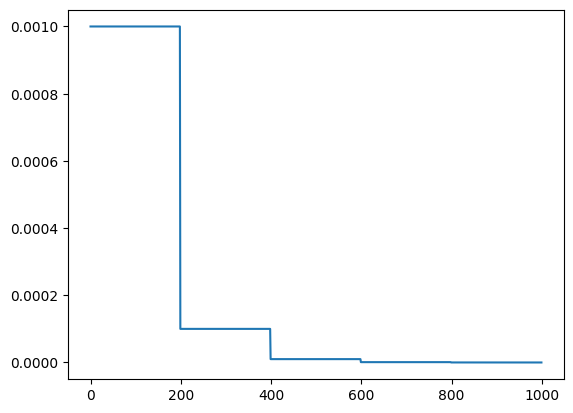

In [34]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

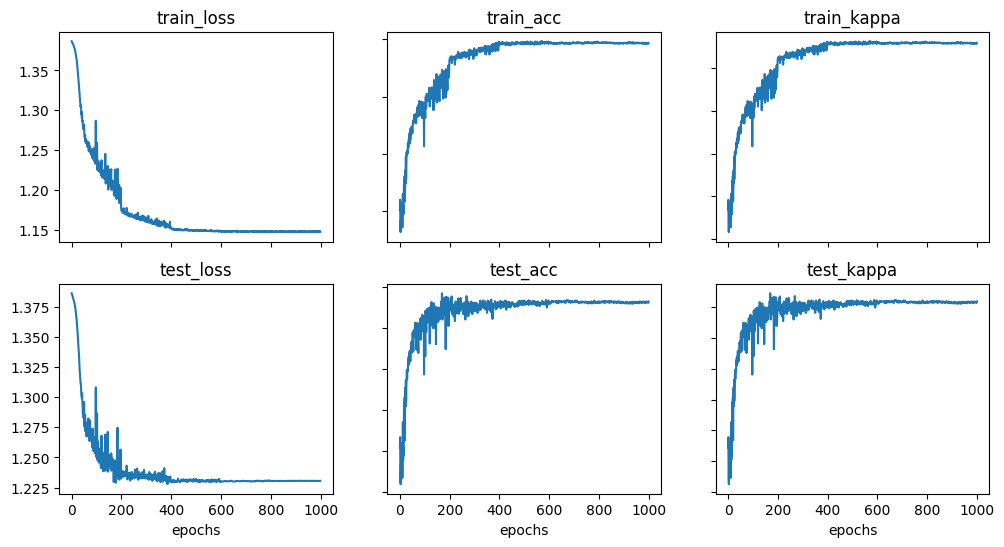

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [36]:
a = 0.3549382716049383
print(f"{a:.2}")

0.35
